# **Лабораторная работа 2**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Панков Евгений Ромуальдович**

## **Задание 1. Обучить 2 классификатора на основе глубоких нейронных сетей на датасете `GTSRB`**

Использовать следующие модели нейронных сетей: `VGG16`, `ResNet50/10X`, `MobileNet v2/3`. Можно использовать фреймворки `Keras`, `TensorFlow`, `PyTorch`, не надо создавать сети вручную и с нуля. Использовать предобученные сети (например на ImageNet).

Выполнить поиск наилучших гиперпараметров моделей. Использовать бесплатные
ресурсы GPU сервиса Google Colab.

**Составить отчёт:**

(a) Заполнить Таблицу сравнения двух моделей.

(b) Для каждой модели построить графики функции потерь для данных валидации и тестирования и графики метрики `Accuracy`.

### **Установим библиотеку ART:**

In [1]:
! pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.3 MB/s eta 0:00:00


### **Импортируем необходимые для работы библиотеки:**

In [2]:
import cv2
import kagglehub
import os
import torch
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

### **Загружаем датасет `gtsrb-german-traffic-sign`:**

In [3]:
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:06<00:00, 107MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


### **Перейдем в директорию с полученными файлами:**

In [4]:
%cd $path

/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [5]:
!ls

meta  Meta  Meta.csv  test  Test  Test.csv  train  Train  Train.csv


### **Задаём пути к полученным данным датасета `gtsrb-german-traffic-sign`:**

In [6]:
data_path = path
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

### **Получим и выполним предварительную обработку изображений из треннировочного набора данных:**

In [7]:
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
print("data[0]:\n",data[0])

data[0]:
 [[[0.47058824 0.49019608 0.5058824 ]
  [0.47058824 0.47843137 0.49803922]
  [0.4862745  0.4862745  0.5058824 ]
  ...
  [0.46666667 0.47058824 0.47843137]
  [0.4627451  0.46666667 0.45882353]
  [0.45490196 0.4627451  0.46666667]]

 [[0.4862745  0.49803922 0.50980395]
  [0.48235294 0.49019608 0.5019608 ]
  [0.47843137 0.48235294 0.5019608 ]
  ...
  [0.49019608 0.49411765 0.5137255 ]
  [0.4745098  0.47058824 0.4627451 ]
  [0.46666667 0.4509804  0.45490196]]

 [[0.49411765 0.5019608  0.5411765 ]
  [0.49803922 0.5058824  0.54901963]
  [0.4862745  0.49803922 0.54509807]
  ...
  [0.6039216  0.60784316 0.6313726 ]
  [0.5411765  0.52156866 0.5372549 ]
  [0.53333336 0.49019608 0.50980395]]

 ...

 [[0.34117648 0.36078432 0.3647059 ]
  [0.34901962 0.36078432 0.36078432]
  [0.3529412  0.35686275 0.36078432]
  ...
  [0.39607844 0.42745098 0.4509804 ]
  [0.36862746 0.3882353  0.4       ]
  [0.37254903 0.38431373 0.3882353 ]]

 [[0.33333334 0.34117648 0.34901962]
  [0.34117648 0.34901962 0.

### **Просморим первый элемент данных в виде изображения:**

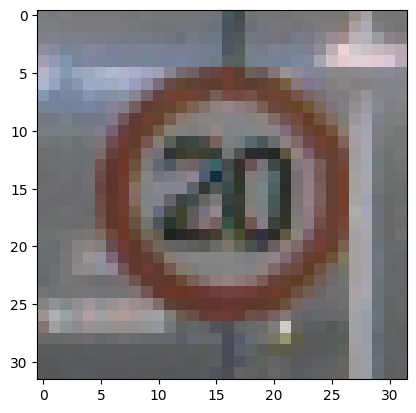

In [8]:
plt.imshow(data[0])

### **Выполним разделение данных на треннировочный и тестовый набор в оотношениях 70/30 и посмотрим полученные размерности наборов:**

In [9]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### **Создадим модель глубокого обучения для классификации изображений `ResNet50`:**

In [10]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 23,545,643 (89.82 MB)

 Non-trainable params: 577,664 (2.20 MB)

None


### **Обучаем модель, исользуя 5 эпох обучения. Включаем оптимизатор `Adam` и функцию потерь `Categorical Crossentropy`:**

In [11]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 104s 115ms/step - accuracy: 0.5561 - loss: 1.8216 - val_accuracy: 0.1142 - val_loss: 5.3294
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.9373 - loss: 0.2185 - val_accuracy: 0.8127 - val_loss: 0.8774
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9676 - loss: 0.1211 - val_accuracy: 0.8647 - val_loss: 2.1519
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9646 - loss: 0.1559 - val_accuracy: 0.9470 - val_loss: 0.1821
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9822 - loss: 0.0697 - val_accuracy: 0.9669 - val_loss: 0.1248


### **Сохраняем полученную выше модаль для дальнейшего анализа и сравнения:**

In [12]:
save_model(model, 'ResNet50.h5')
save_model(model, '/content/ResNet50.h5')

### **Считаем данные из `Test.csv` в датафрейм, где содержатся оригинальная метка класса и путь к изображению:**

In [13]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

### **Переходим к созданию модели для классификации изображений `VGG16`:**

In [14]:
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
print(model2.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,857,067 (56.68 MB)

 Trainable params: 14,725,739 (56.17 MB)

 Non-trainable params: 131,328 (513.00 KB)

None


### **Обучаем модель, исользуя 5 эпох обучения. Включаем оптимизатор `Adam` и функцию потерь `Categorical Crossentropy`:**

In [15]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.0932 - loss: 3.4165 - val_accuracy: 0.4196 - val_loss: 1.7389
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.4674 - loss: 1.5979 - val_accuracy: 0.8182 - val_loss: 0.5141
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8196 - loss: 0.5073 - val_accuracy: 0.9185 - val_loss: 0.2558
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9262 - loss: 0.2334 - val_accuracy: 0.9518 - val_loss: 0.1590
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9585 - loss: 0.1391 - val_accuracy: 0.9798 - val_loss: 0.0734


### **Сохраняем полученную выше модаль для дальнейшего анализа и сравнения:**

In [16]:
save_model(model2, 'VGG16.h5')
save_model(model2, '/content/VGG16.h5')

### **Выполним оценку производительности двух моделей на тестовом наборе данных:**

In [17]:
history_test = model.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))
history2_test = model2.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.9727 - loss: 0.1016 - val_accuracy: 0.9648 - val_loss: 0.1119
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9771 - loss: 0.0797 - val_accuracy: 0.9362 - val_loss: 0.5793
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9777 - loss: 0.1167 - val_accuracy: 0.9153 - val_loss: 0.7900
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9866 - loss: 0.0535 - val_accuracy: 0.9726 - val_loss: 0.0968
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9836 - loss: 0.0565 - val_accuracy: 0.9663 - val_loss: 0.1530
Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9624 - loss: 0.1443 - val_accuracy: 0.9759 - val_loss: 0.0920
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9708 - loss: 0.1196 - val_accuracy: 0.9719 - val_loss: 0.0981
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9618 - loss: 0.1418 - val_accurac

### **(а) Создадим и отобразим таблицу, которая показывает точность обоих моделей на треннировочном, валидационном и тестовом наборах данных:**

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history_test.history['accuracy']

train_accuracy2 = history2_test.history['accuracy']
val_accuracy2 = history2_test.history['val_accuracy']
test_accuracy2 = history2_test.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)

+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             98.1673 |               96.693  |         98.2998 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             98.2147 |               98.6143 |         98.2147 |
+----------+---------------------+-----------------------+-----------------+


**Как видно из таблицы, модели показывают схожие результаты, немного лучше по валидации оказалась модель `VGG16`**

### **(б) Строим графики функции потерь для данных валидации и тестирования и графики метрики `Accuracy` для двух моделей:**

#### **Для модели `ResNet50`:**

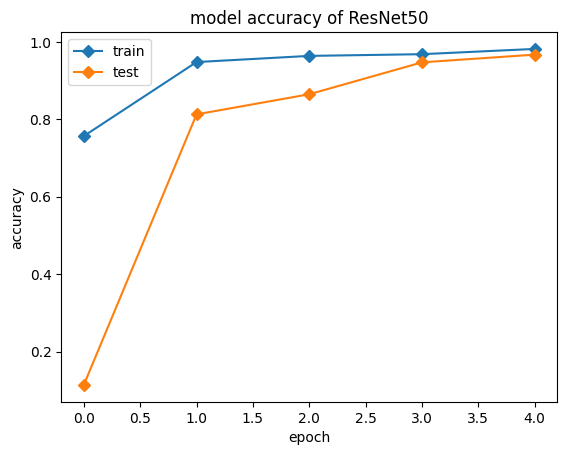

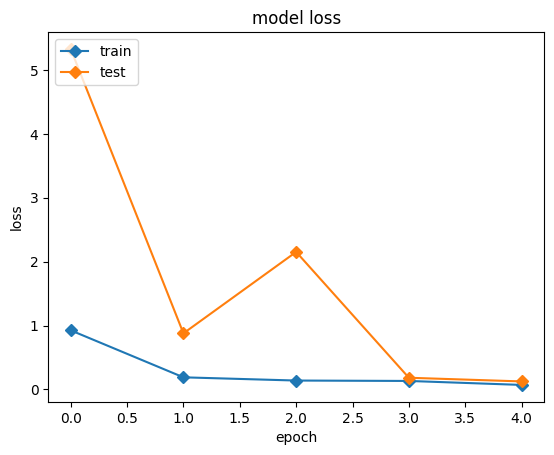

In [19]:
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### **Для модели `VGG16`:**

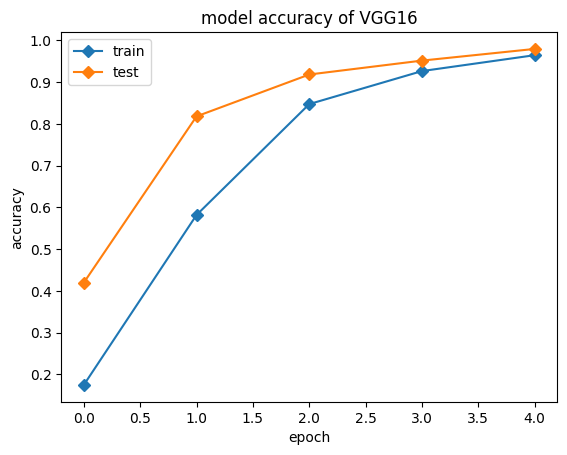

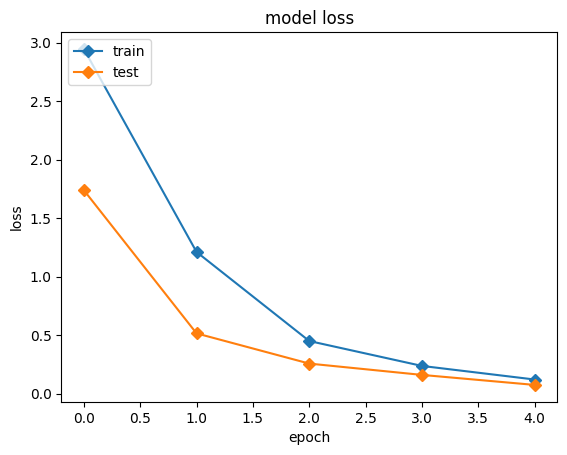

In [20]:
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Задание 2. Применить нецелевую атаку уклонения на основе белого ящика против моделей глубокого обучения**

Реализовать следующие типы атак: `Fast Gradient Sign Method` (`FGSM`) и `Projected Gradient Descent` (`PGD`).

Может быть использован код из следующих библиотек: `Adversarial Robustness Toolbox ART`, `Cleverhans CH`, `scratchai SC`. Наиболее проработанная библиотека – `Adversarial Robustness Toolbox`, рекомендуется использовать её, но другие также могут быть применены. Например, `this notebook` объясняет как использовать `ART` с помощью `Keras`. Также есть другие notebooks с примерами атак на основе библиотеки `ART`.

Используйте атаки `FSGM` и `PGD` для создания нецелевых атакующих примеров используя первые 1,000 изображений из тестового множества.

Необходимо использовать следующие значения параметра искажения: 𝜖𝜖=[1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255].

Постройте графики точности 2-х моделей в зависимости от параметра искажений 𝜖𝜖.

Для атаки FGSM, отобразите исходное изображение из датасета и атакующее изображение с указанием величины параметра 𝜖𝜖= [1/255, 5/255, 10/255, 50/255, 80/255], отобразите предсказанный класс атакующего изображения.

**Отчёт должен содержать:**

(a) Заполненную таблицу . Все модели должны иметь точность менее 60% для 𝜖𝜖=10/255;

(b) Для каждой модели постройте график зависимости точности классификации от параметра искажений 𝜖𝜖;

(c) Сделать выводы о полученных результатах.

### **Загрузим сохраненную ранее модель `ResNet50` и берем тысячу первых элементов из тестового множества, создаем классификатор `ART`:**

In [21]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

### **Создадим атаку `FGSM`:**

In [22]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.7496 - loss: 1.3840
Adv Loss: 1.4031180143356323
Adv Accuracy: 0.7480000257492065
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9252 - loss: 0.3194
True Loss: 0.30505138635635376
True Accuracy: 0.921999990940094
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6181 - loss: 2.4348
Adv Loss: 2.497896432876587
Adv Accuracy: 0.6060000061988831
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9252 - loss: 0.3194
True Loss: 0.30505138635635376
True Accuracy: 0.921999990940094
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5031 - loss: 3.3103
Adv Loss: 3.4067893028259277
Adv Accuracy: 0.49300000071525574
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9252 - loss: 0.3194
True Loss: 0.30505138635635376
True Accuracy: 0.921999990940094
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4288 - loss: 4.0275
Adv Lo

### **Cохраним атаку `FGSM` для дальнейшего использования в исследовании (графики):**

In [23]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

### **Отображаем исходное и `Adversarial` изображения для разных значений eps после атаки `FGSM`:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


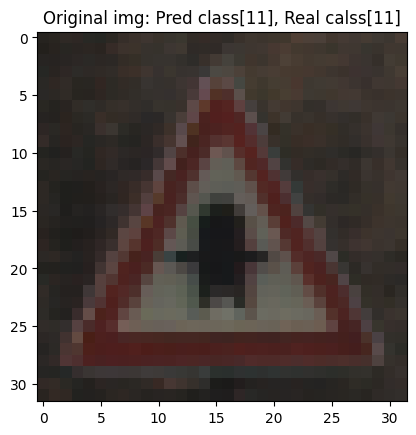

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


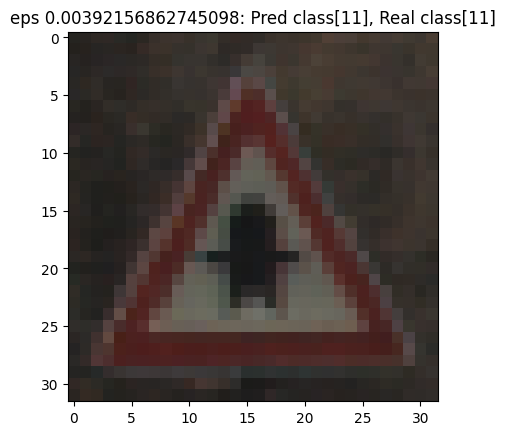

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


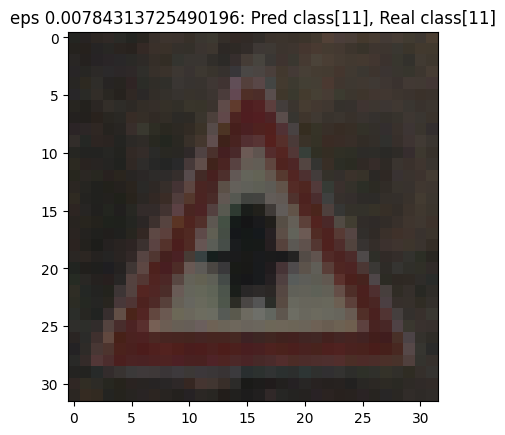

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


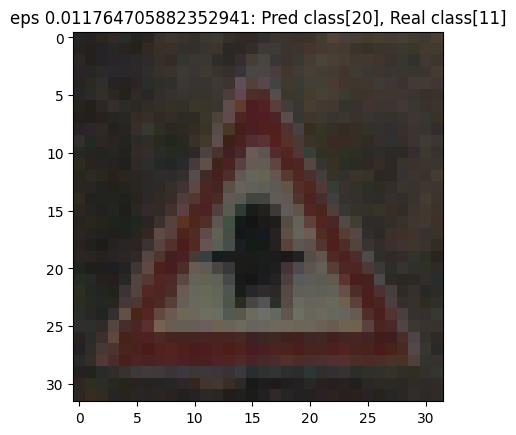

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


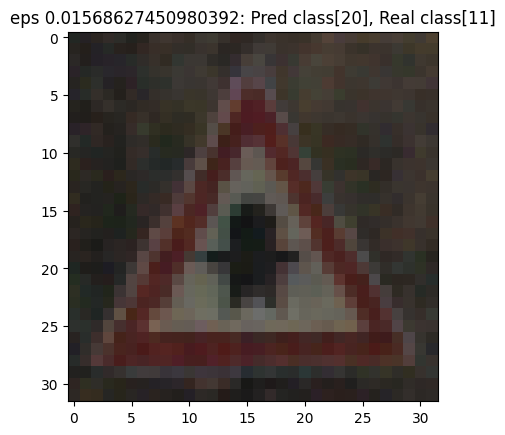

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


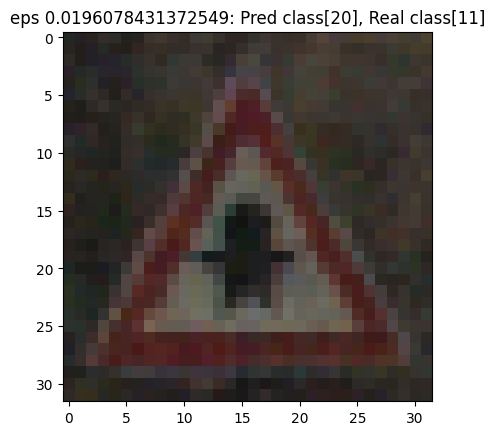

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


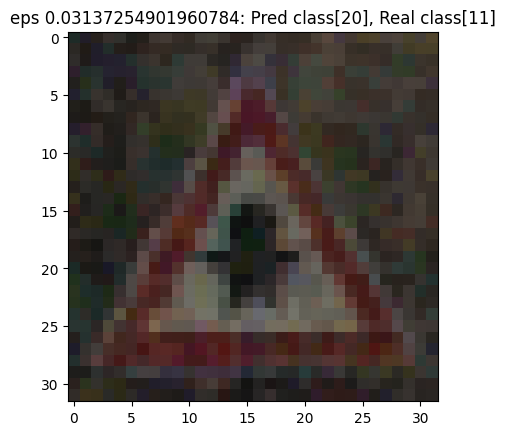

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


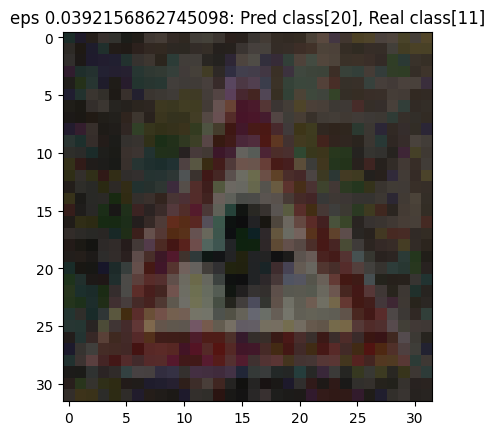

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


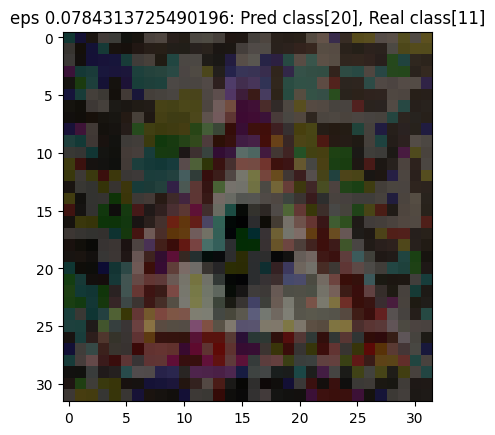

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


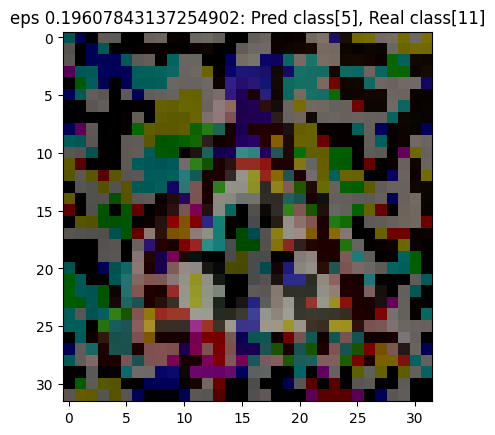

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


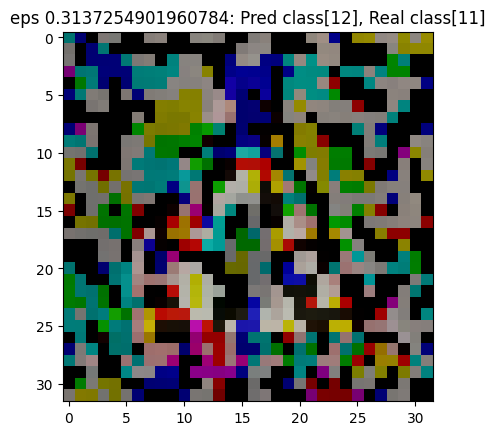

In [24]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

**Ошибки предсказания из-за наложенного шума начались со значения 2/225**

### **Перейдем к реализации атаки `PGD` для той же модели:**

In [25]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

In [26]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7228 - loss: 1.6425
Adv Loss: 1.6560629606246948
Adv Accuracy: 0.7170000076293945
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9252 - loss: 0.3194
True Loss: 0.30505138635635376
True Accuracy: 0.921999990940094
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5771 - loss: 2.9521
Adv Loss: 3.0163793563842773
Adv Accuracy: 0.5590000152587891
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9252 - loss: 0.3194
True Loss: 0.30505138635635376
True Accuracy: 0.921999990940094
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4624 - loss: 4.1286
Adv Loss: 4.252498626708984
Adv Accuracy: 0.44699999690055847
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9252 - loss: 0.3194
True Loss: 0.30505138635635376
True Accuracy: 0.921999990940094
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4039 - loss: 4.9033
Adv L

### **Cохраним атаку `PGD` для дальнейшего использования в исследовании (графики):**

In [27]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)

### **Отображаем исходное и `Adversarial` изображения для разных значений eps после атаки `PGD`:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


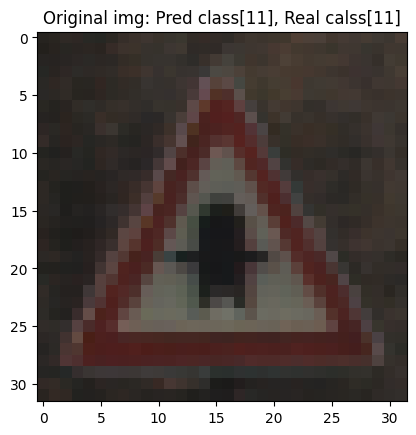

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


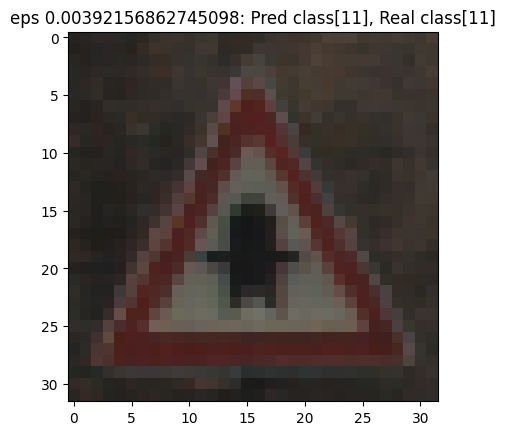

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


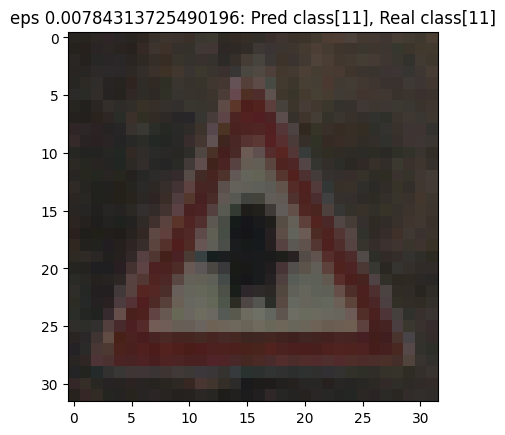

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


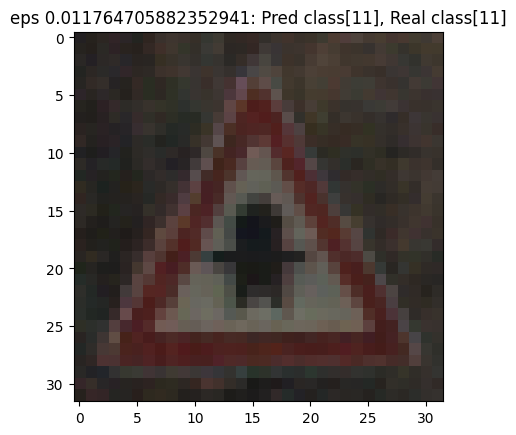

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


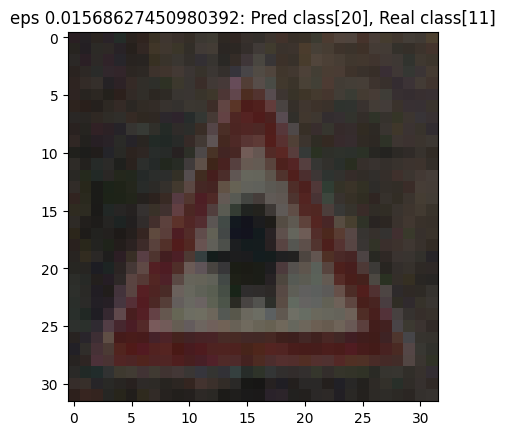

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


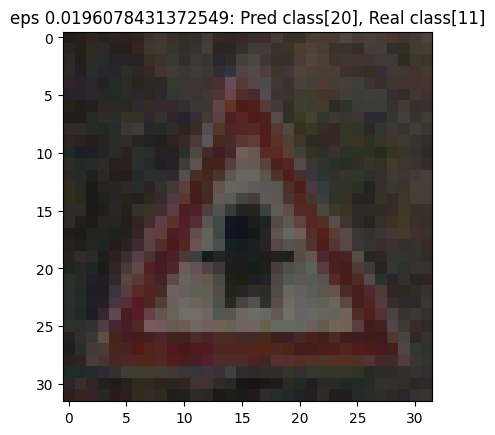

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


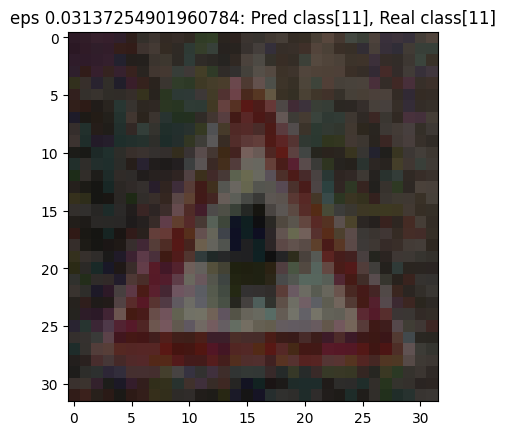

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


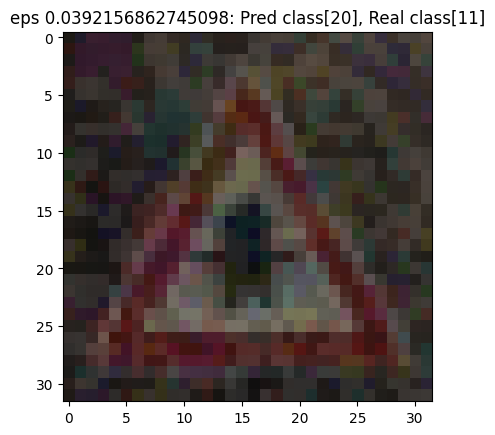

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


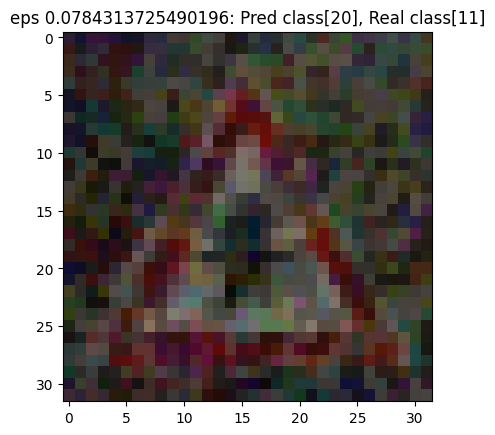

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


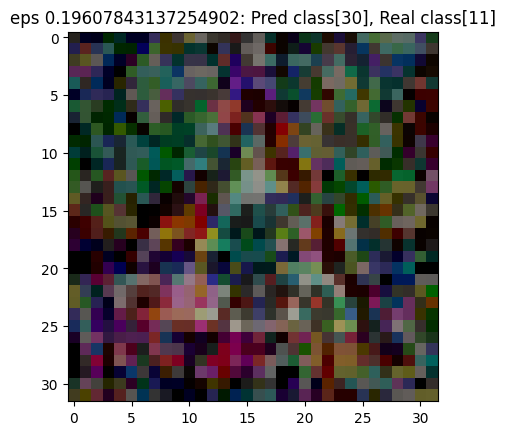

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


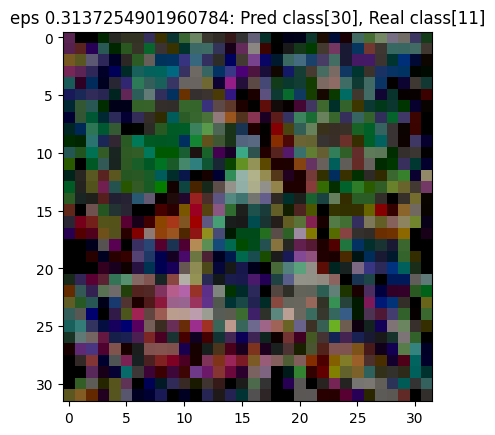

In [28]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

**Ошибки предсказания из-за наложенного шума также начались со значения 2/225**

### **Перейдем к визуализации графиков сравнения полученных результатов по `ResNet50`:**

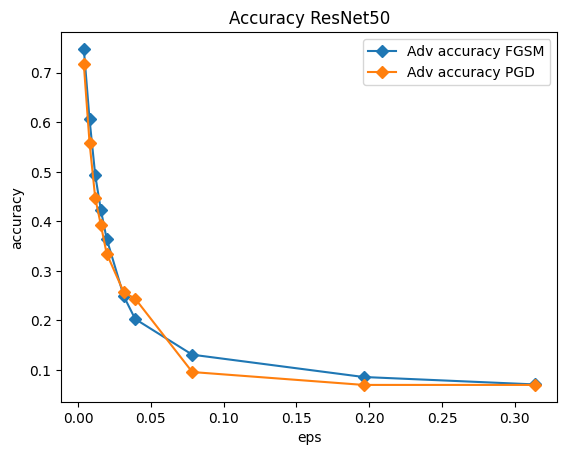

In [29]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### **Теперь загрузим сохраненную ранее модель `VGG16` и берем тысячу первых элементов из тестового множества, создаем классификатор `ART`:****

In [30]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

### **Создадим атаку `FGSM`:**

In [31]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8357 - loss: 0.7989
Adv Loss: 0.8526002764701843
Adv Accuracy: 0.8320000171661377
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9421 - loss: 0.2643
True Loss: 0.3001163899898529
True Accuracy: 0.9350000023841858
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7465 - loss: 1.4483
Adv Loss: 1.530086636543274
Adv Accuracy: 0.7360000014305115
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9421 - loss: 0.2643
True Loss: 0.3001163899898529
True Accuracy: 0.9350000023841858
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6824 - loss: 2.0344
Adv Loss: 2.145631790161133
Adv Accuracy: 0.6610000133514404
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9421 - loss: 0.2643
True Loss: 0.3001163899898529
True Accuracy: 0.9350000023841858
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6469 - loss: 2.4271
Adv Loss: 2

### **Cохраним атаку `FGSM` для дальнейшего использования в исследовании (графики):**

In [32]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

### **Отображаем исходное и `Adversarial` изображения для разных значений eps после атаки `FGSM`:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


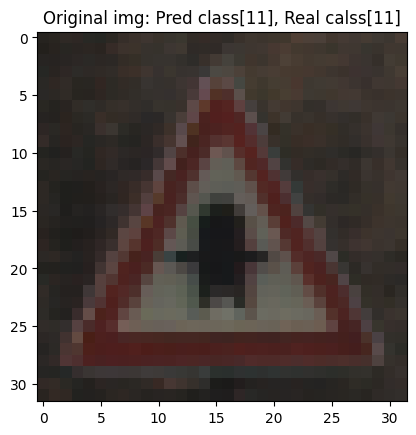

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


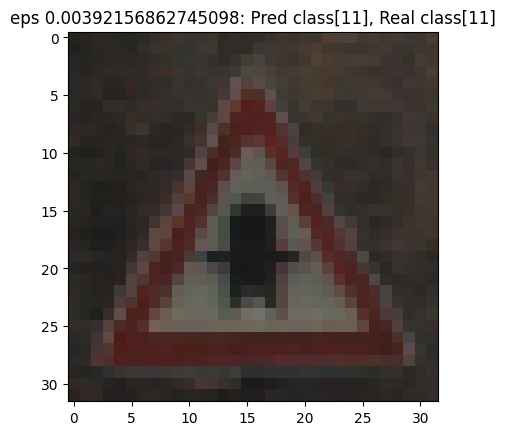

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


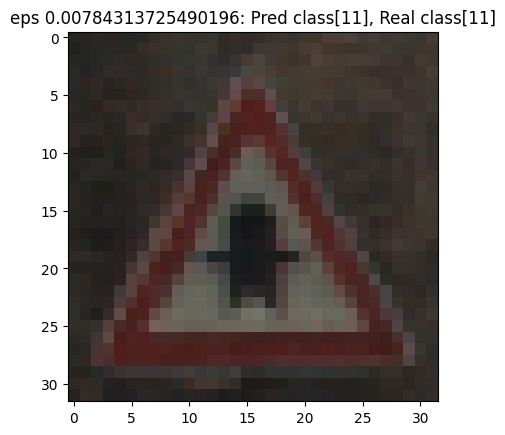

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


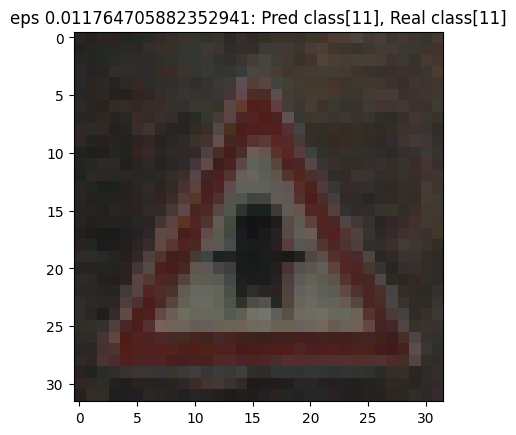

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


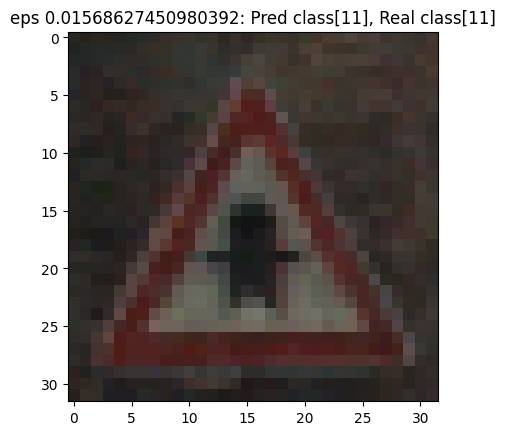

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


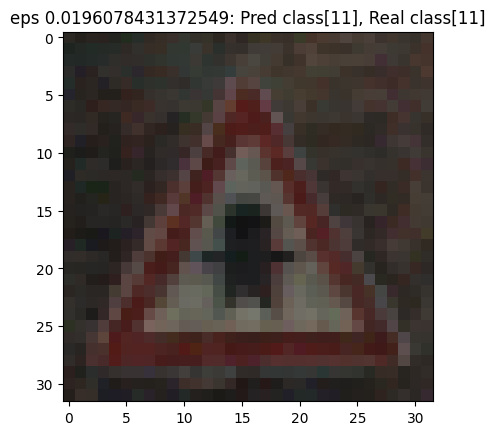

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


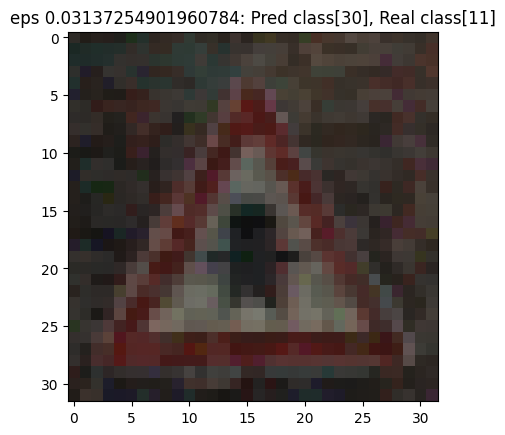

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


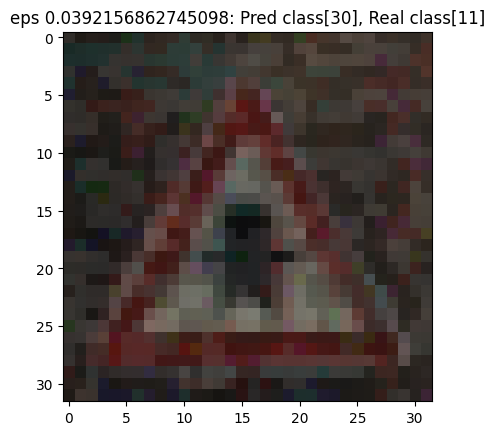

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


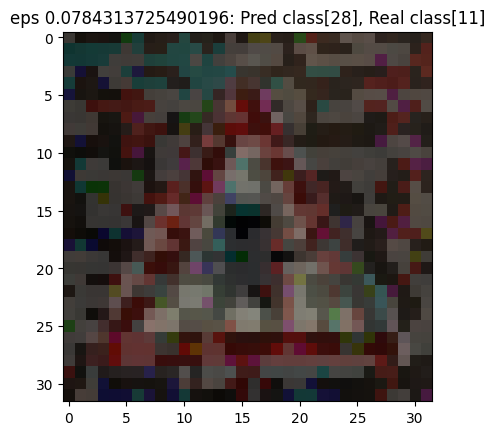

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


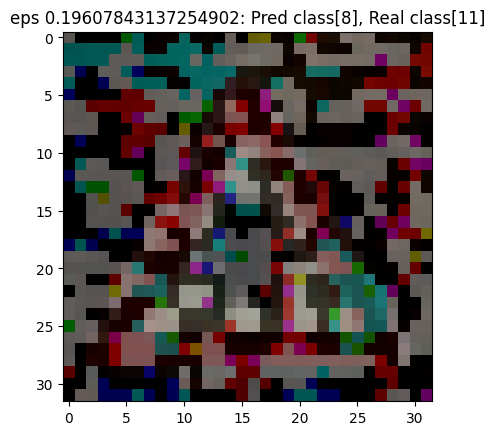

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


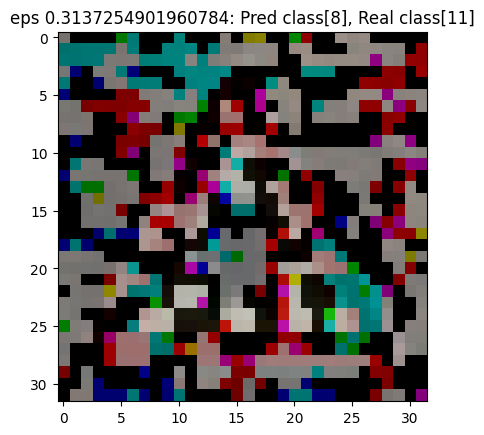

In [33]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

**Ошибки предсказания из-за наложенного шума была получена на значения 8/225**

### **Перейдем к реализации атаки `PGD` для той же модели:**

In [34]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

In [35]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8168 - loss: 0.9621
Adv Loss: 1.0079448223114014
Adv Accuracy: 0.8130000233650208
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9421 - loss: 0.2643
True Loss: 0.3001163899898529
True Accuracy: 0.9350000023841858
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7284 - loss: 1.7555
Adv Loss: 1.8845908641815186
Adv Accuracy: 0.7039999961853027
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9421 - loss: 0.2643
True Loss: 0.3001163899898529
True Accuracy: 0.9350000023841858
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6625 - loss: 2.3527
Adv Loss: 2.6039600372314453
Adv Accuracy: 0.6430000066757202
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9421 - loss: 0.2643
True Loss: 0.3001163899898529
True Accuracy: 0.9350000023841858
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6292 - loss: 2.9958
Adv Loss

### **Cохраним атаку `PGD` для дальнейшего использования в исследовании (графики):**

In [36]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

### **Отображаем исходное и `Adversarial` изображения для разных значений eps после атаки `PGD`:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


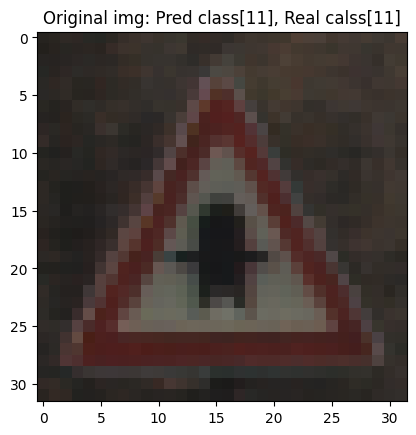

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


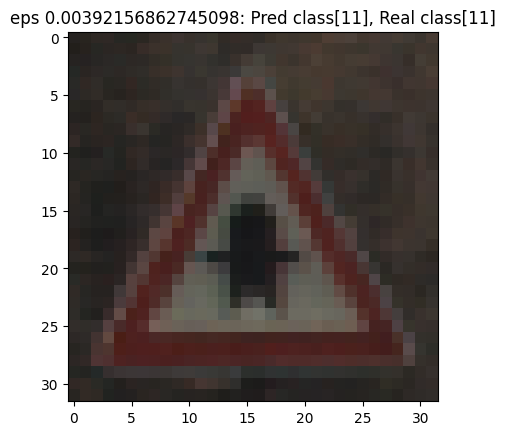

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


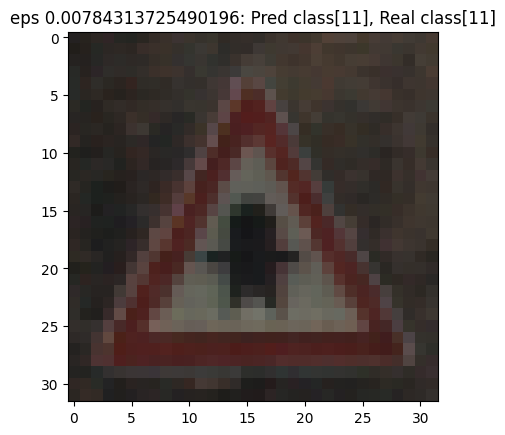

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


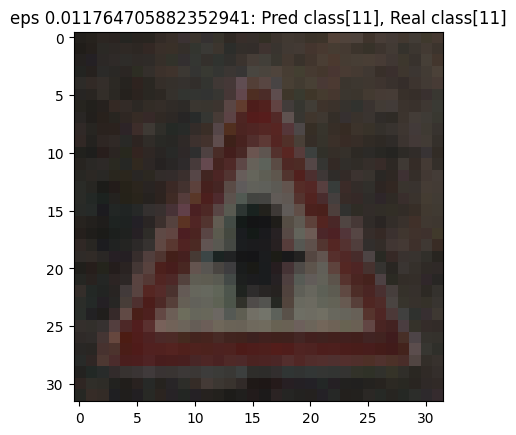

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


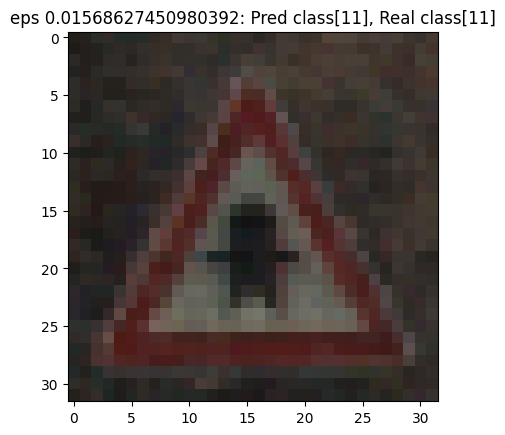

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


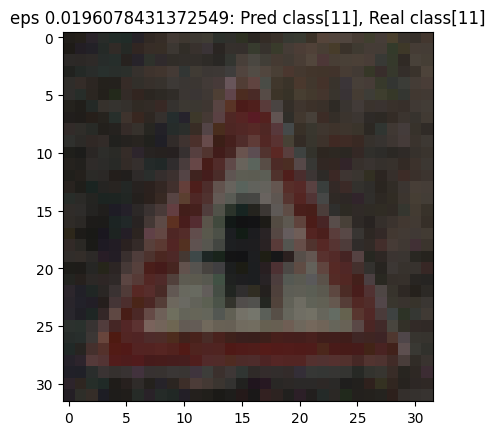

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


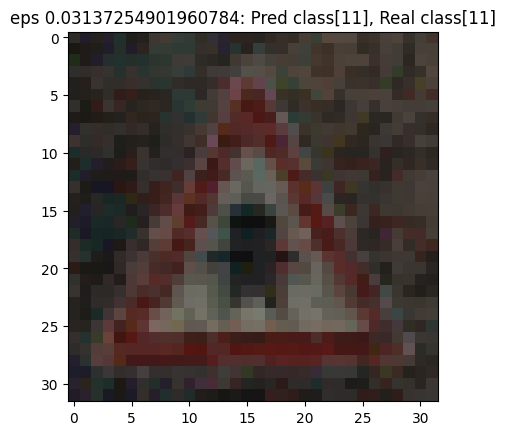

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


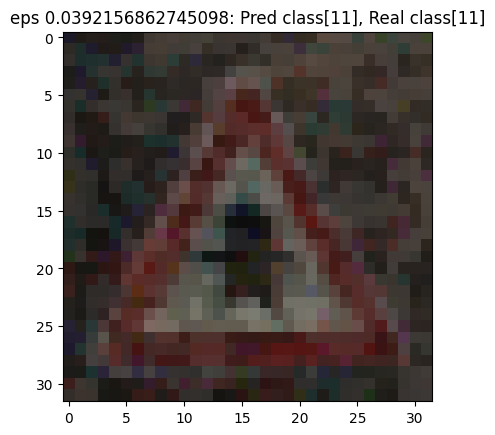

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


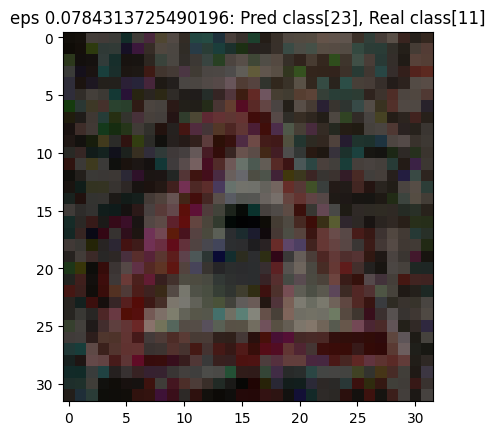

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


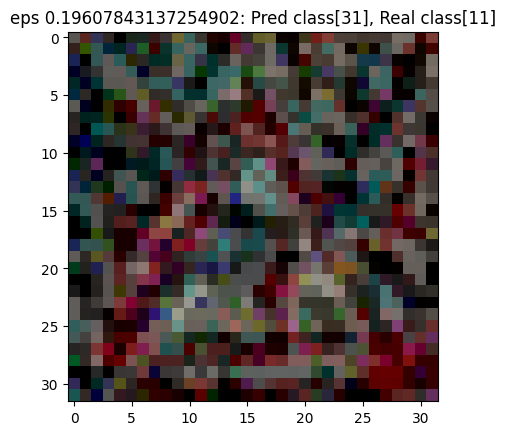

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


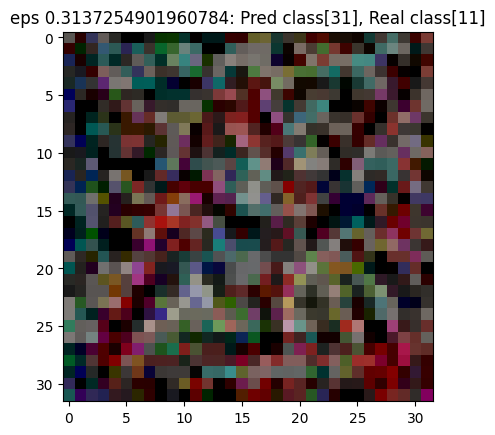

In [37]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

**Ошибки предсказания из-за наложенного шума была получена на значения 4/225**

### **Перейдем к визуализации графиков сравнения полученных результатов по `VGG16`:**

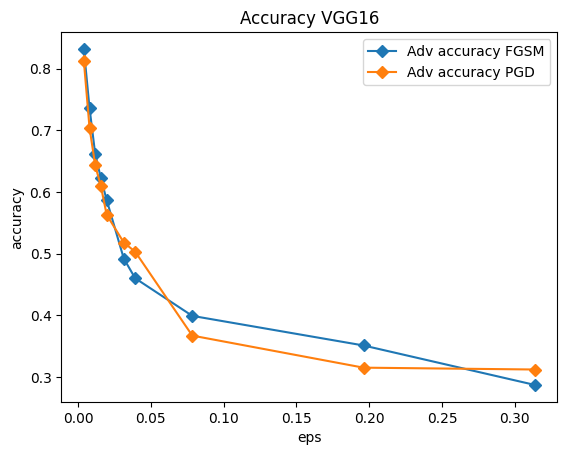

In [38]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### **Выводы:**

В случае `VGG16`, при атаках `PGD` и `FGSM` сначала наблюдается одинаковое снижение точности. Однако с увеличением значений eps в какой-то момент точность при атаке `PGD` начинает снижаться более резко. Тем не менее, при максимальном значении eps наибольшее падение точности фиксируется именно при атаке `FGSM`. Кроме того, атаки в случае `VGG16` реализуются кратно быстрее `ResNet50`.

**Представим итоговую таблицу сравнения по `VGG16` и `ResNet50`:**

In [39]:
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_fgsm_v16 = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 FGSM",train_accuracy2[4]*100,adv_acc_fgsm_v16[0]*100,
             adv_acc_fgsm_v16[1]*100,adv_acc_fgsm_v16[2]*100,adv_acc_fgsm_v16[3]*100,
             adv_acc_fgsm_v16[4]*100,adv_acc_fgsm_v16[5]*100,adv_acc_fgsm_v16[6]*100,
             adv_acc_fgsm_v16[7]*100,adv_acc_fgsm_v16[8]*100,adv_acc_fgsm_v16[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+
| Model         |   Original accuracy |   eps = 1/255 |   eps = 2/255 |   eps = 3/255 |   eps = 4/255 |   eps = 5/255 |   eps = 8/255 |   eps = 10/255 |   eps = 20/255 |   eps = 50/255 |   eps = 80/255 |
+===============+=====================+===============+===============+===============+===============+===============+===============+================+================+================+================+
| Resnet50 FGSM |             98.1673 |          74.8 |          60.6 |          49.3 |          42.2 |          36.5 |          24.9 |           20.3 |           13.1 |            8.6 |            7.1 |
+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------

**По таблице видно, что точность выше при всех значениях eps у модели `VGG16`**

## **Задание 3. Применение целевой атаки уклонения методом белого против моделей глубокого обучения**

Шаг 1: Используйте изображения знака «Стоп» (label class 14) из тестового
набора данных. Всего имеется 270 изображений. Примените атаку `Projected
Gradient Descent` (`PGD`) на знак «Стоп»  с целью классификации его как знака
«Ограничение скорости 30» (target label class = 1). Изменяйте значения
искажений 𝜖𝜖= [1/255, 3/255, 5/255, 10/255, 20/255, 50/255, 80/255], и заполните отчёт значениями точности классификации изображений знаков "Стоп" и
"Ограничение скорости 30".  

Шаг 2: Повторите атаку методом `FGSM`, и объясните производительность по
сравнению с `PGD`.

**Отчёт должен содержать:**

(a) Заполненную таблицу.
Объясните какой размер искажений достигает максимальной производительности и объясните причины.

(b) Постройте 5 примеров
исходных изображений знака «Стоп» и соответствующих атакующих

### **Загружаем тестовый набор данных из Test.csv и извлекаем изображения с меткой 14, преобразуем изображения в массив чисел и нормализуем:**

In [40]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

### **Реализуем целевую атаку `FGSM`:**

In [41]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
tar_accuracises_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    tar_accuracises_fgsm.append(accuracy)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")


Eps: 0.00392156862745098
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.9248 - loss: 0.3389
Adv Loss: 0.3464672565460205
Adv Accuracy: 0.9222221970558167
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0032
True Loss: 0.0038786204531788826
True Accuracy: 1.0
Eps: 0.00784313725490196
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8566 - loss: 0.9042
Adv Loss: 0.9847496747970581
Adv Accuracy: 0.8296296000480652
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0032
True Loss: 0.0038786204531788826
True Accuracy: 1.0
Eps: 0.011764705882352941
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7758 - loss: 1.4049
Adv Loss: 1.583892583847046
Adv Accuracy: 0.7370370626449585
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0032
True Loss: 0.0038786204531788826
True Accuracy: 1.0
Eps: 0.01568627450980392
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6913 - loss: 1.8646
Adv Loss: 2.103238344192505
Adv Accuracy: 0.662962973

In [42]:
tar_accuracises_fgsm = np.array(tar_accuracises_fgsm)
np.save("tar_accuracies_fgsm_ResNet50",tar_accuracises_fgsm)

In [43]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

### **Отобразим 5 разных изображений для визуализации действия атаки:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


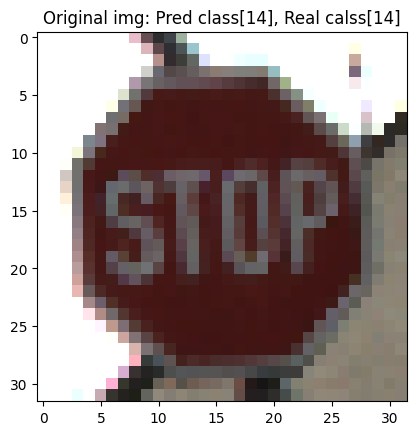

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


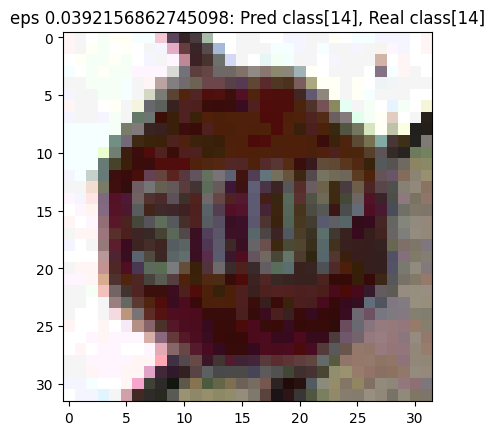

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


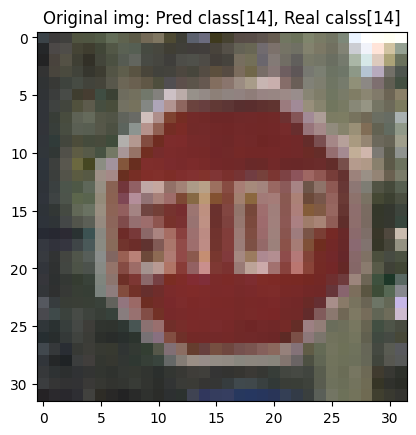

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


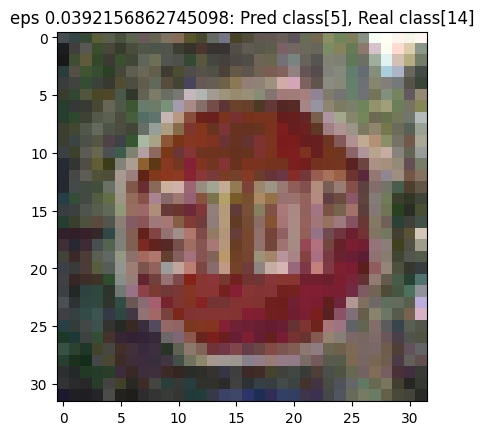

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


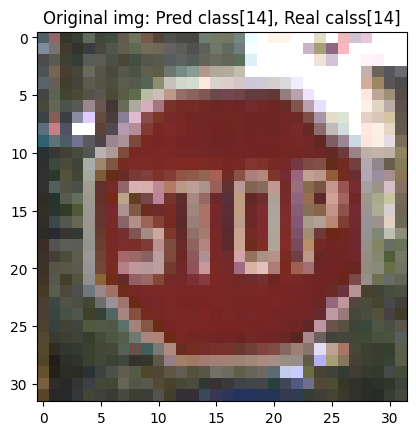

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


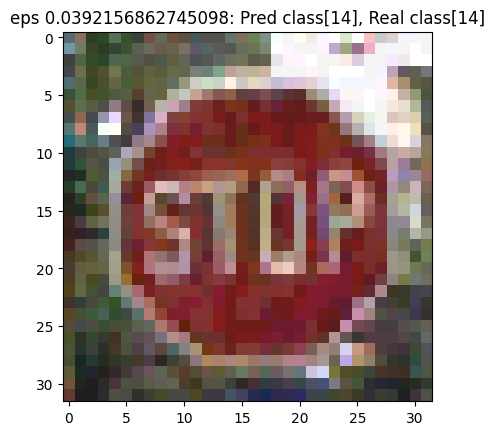

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


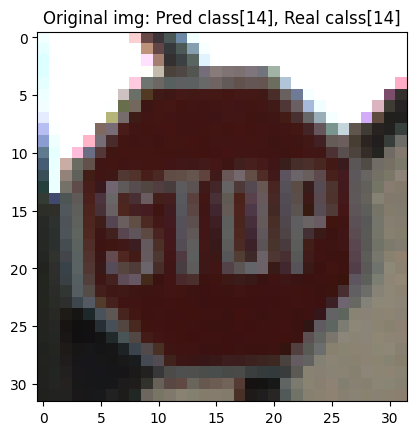

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


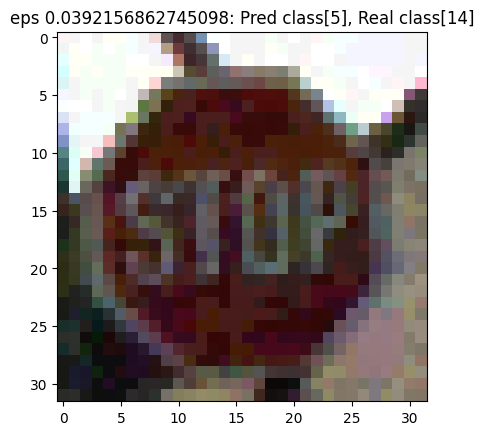

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


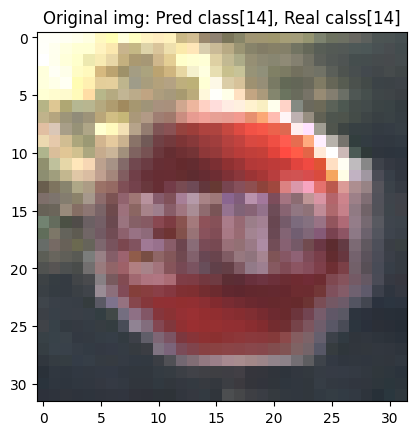

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


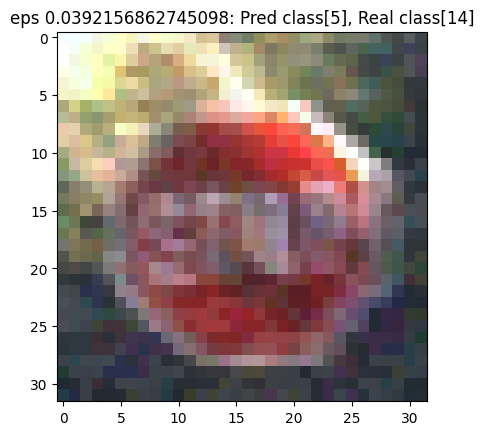

In [44]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

### **Вывод:**

Целевая атака `FGSM` достигает своего пика на eps = 10/255 в нашем случе, при больших значениях eps атака хоть и будет давать больше неточности при предсказании, но это будут разные классы, в большинстве случаев отличные от первого (знак стоп), который мы указали. Можно сделать вывод, что `FGSM` не очень подходит для целевых атак.

### **Реализуем целевую атаку `PGD`:**

In [45]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
tar_accuracises_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    tar_accuracises_pgd.append(accuracy)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.9955 - loss: 0.0304
Adv Loss: 0.034426260739564896
Adv Accuracy: 0.9962962865829468
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0032
True Loss: 0.0038786204531788826
True Accuracy: 1.0
Eps: 0.00784313725490196
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9708 - loss: 0.1392
Adv Loss: 0.19791395962238312
Adv Accuracy: 0.9629629850387573
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0032
True Loss: 0.0038786204531788826
True Accuracy: 1.0
Eps: 0.011764705882352941
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9197 - loss: 0.3339
Adv Loss: 0.3599066138267517
Adv Accuracy: 0.9185185432434082
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0032
True Loss: 0.0038786204531788826
True Accuracy: 1.0
Eps: 0.01568627450980392
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9238 - loss: 0.4399
Adv Loss: 0.4816528856754303
Adv Accuracy: 0.9074

In [46]:
tar_accuracises_pgd = np.array(tar_accuracises_pgd)
np.save("tar_accuracies_pgd_ResNet50",tar_accuracises_pgd)

In [47]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

### **Отобразим 5 разных изображений для визуализации действия атаки:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


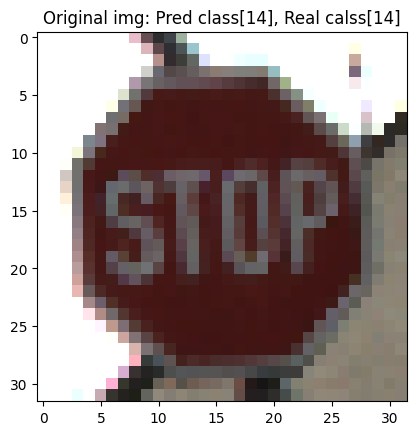

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


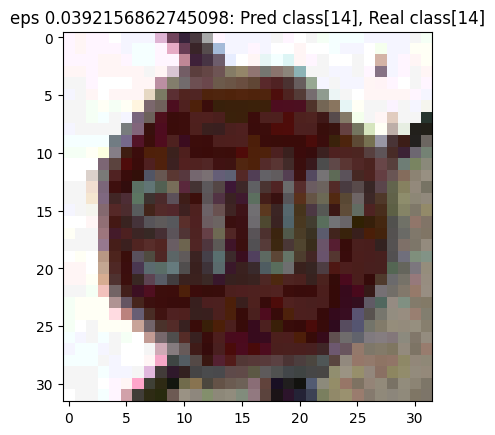

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


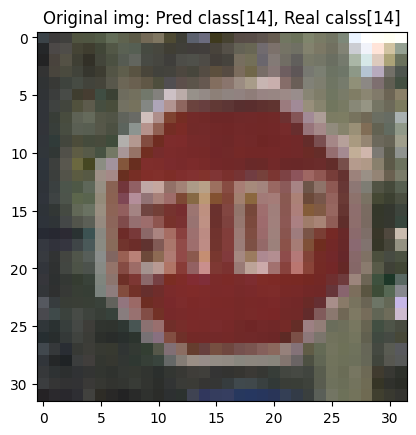

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


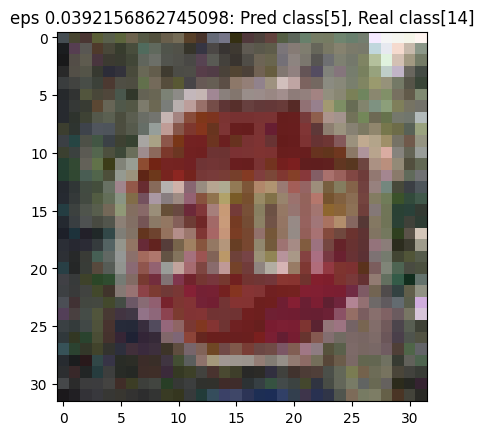

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


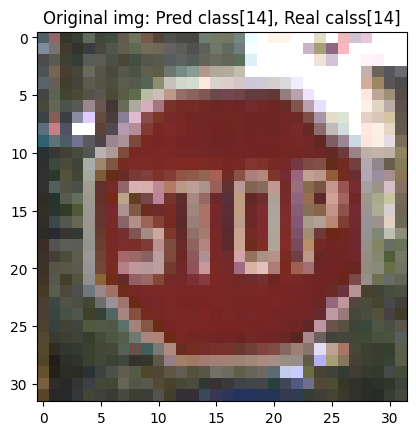

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


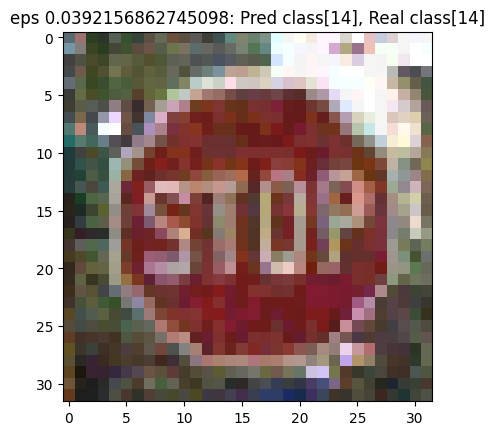

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


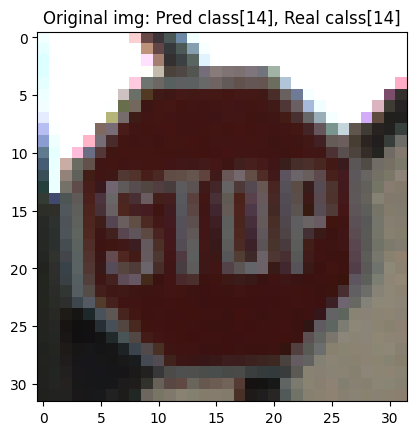

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


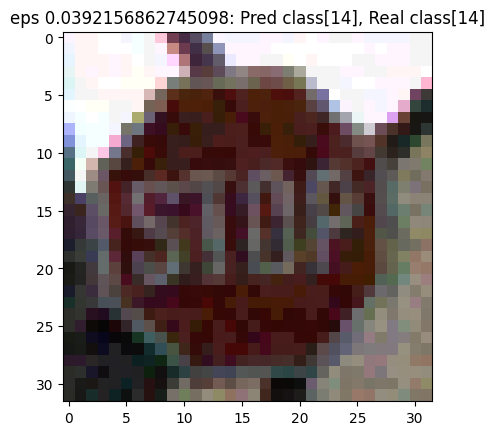

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


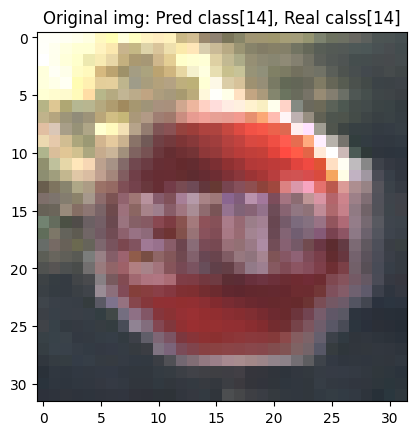

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


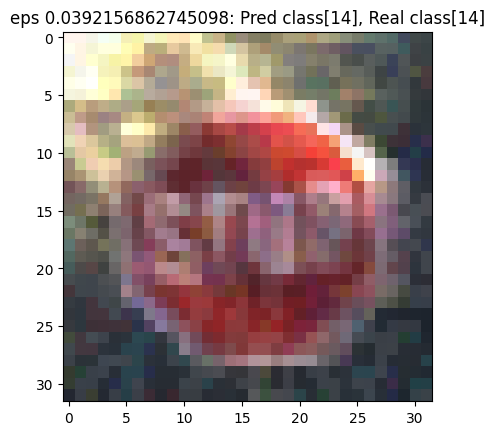

In [48]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

### **Вывод таблицы с результатами для сравнения:**

In [49]:
eps_values_acc = ["1/255", "2/255", "3/255", "4/255", "5/255", "8/255", "10/255", "20/255", "50/255", "80/255"]
tar_acc_fgsm_rn50 = np.load("tar_accuracies_fgsm_ResNet50.npy")
tar_acc_pdp_rn50 = np.load("tar_accuracies_pgd_ResNet50.npy")

table = [["Искажение","FGSM","PGD"],
            [eps_values_acc[0],tar_acc_fgsm_rn50[0],tar_acc_pdp_rn50[0]],
            [eps_values_acc[1],tar_acc_fgsm_rn50[1],tar_acc_pdp_rn50[1]],
            [eps_values_acc[2],tar_acc_fgsm_rn50[2],tar_acc_pdp_rn50[2]],
            [eps_values_acc[3],tar_acc_fgsm_rn50[3],tar_acc_pdp_rn50[3]],
            [eps_values_acc[4],tar_acc_fgsm_rn50[4],tar_acc_pdp_rn50[4]],
            [eps_values_acc[5],tar_acc_fgsm_rn50[5],tar_acc_pdp_rn50[5]],
            [eps_values_acc[6],tar_acc_fgsm_rn50[6],tar_acc_pdp_rn50[6]],
            [eps_values_acc[7],tar_acc_fgsm_rn50[7],tar_acc_pdp_rn50[7]],
            [eps_values_acc[8],tar_acc_fgsm_rn50[8],tar_acc_pdp_rn50[8]],
            [eps_values_acc[9],tar_acc_fgsm_rn50[9],tar_acc_pdp_rn50[9]],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+-------------+----------+-----------+
| Искажение   |     FGSM |       PGD |
+=============+==========+===========+
| 1/255       | 0.922222 | 0.996296  |
+-------------+----------+-----------+
| 2/255       | 0.82963  | 0.962963  |
+-------------+----------+-----------+
| 3/255       | 0.737037 | 0.918519  |
+-------------+----------+-----------+
| 4/255       | 0.662963 | 0.907407  |
+-------------+----------+-----------+
| 5/255       | 0.588889 | 0.874074  |
+-------------+----------+-----------+
| 8/255       | 0.333333 | 0.751852  |
+-------------+----------+-----------+
| 10/255      | 0.185185 | 0.737037  |
+-------------+----------+-----------+
| 20/255      | 0        | 0.5       |
+-------------+----------+-----------+
| 50/255      | 0        | 0.12963   |
+-------------+----------+-----------+
| 80/255      | 0        | 0.0703704 |
+-------------+----------+-----------+


### **Вывод:**

Атака `PGD` достигает отличных значений при eps 50/255, при таком значении очень много требуемых результатов.

Как видим, атака `PGD` дольше сохранеяет точность, чем `FGSM`. При этом `PGD` намного лучше подходит для целевых атак, так как на больших значениях eps выдает лучший требуемый (класс 1 - знак стоп) результат, чем `FGSM`.